In [1]:
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: right;
    vertical-align: middle;
}
</style>
""")

# system ----
import os
import sys
import matplotlib
import h5py
import numpy as np
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.legend_handler import HandlerBase

import warnings
warnings.filterwarnings("ignore",category=FutureWarning)
 
# !!! you will have to edit this to your local computer

# local ----
localPath = os.path.expanduser("~/")
projPath = os.path.expanduser(localPath+"_projects/researchproject_014/")
sys.path.append(projPath+"modules")
import plot_parameters 

# !!! 

***

# Sample Data set

This example dataset consists of the PHAT-ELVIS suite of Milky-way size halos with analytical potential profiles (i.e. the galactic bulge and galactic disk) analogous to the Milky Way

In [2]:
# cosmology
params = {
    'h0'     : 0.6751,
    'omegaM' : 0.3121,
    'omegaL' : 0.6879,
    'omegaB' : 0.0000,
    'omegaR' : 0.0000,
    'boxsize': 1,
    }
h0=params['h0']

# ---- load in dataset
hid=str(988) # specific main halo simulation
# rockstar catalog
cat=np.genfromtxt(projPath+'/outputs/pelvis/halo_catalog_disk_'+hid+'.csv',
                  skip_header=1,delimiter=',')
# merger tree catalog
tree=np.genfromtxt(projPath+'/outputs/pelvis/main_branches_disk_'+hid+'_trimmed.csv',
                   skip_header=1,delimiter=',')

***

# Nomenclature

The target halo of this simulations are Milky Way-mass dark matter halos simulated with a growing potential disk and potential bulge (see https://arxiv.org/abs/1811.12413). The target halo, which we will call the **host halo** is a *isolated* dark matter halo that was simulated. A host halo is typically defined to be a halo that did not form nor currently reside in a larger halo. 

For the contents underneath, check out these slides from http://www.astro.yale.edu/vdbosch/astro610_lecture11.pdf.

### Dark Matter Halos

Dark matter halos are typically defined to be objects that have a density that starkingly contrasts from the background density of the universe, $\rho_{\rm bg}$. For example, the background can be defined by the *critical density*, $\rho_{\rm crit}$, or the *mean matter density*, $\rho_{\rm m} := \Omega_{\rm m}\rho_{\rm crit}$. Typically, halos are defined by the contrast via a overdensity parameter, $\Delta$, giving the halo mass (and radius) as

\begin{align}
M_{\Delta} := \frac{4\pi R_{\Delta}^{3}}{3} (\Delta \times \rho_{\rm bg}) 
\, ,
\end{align}

Note that $R_{\Delta}$ is *not a physical boundary* of a dark matter halo.

Halos are defined by many definitions overdensity througout the literature, so you need to thoroughly read in methodology sections of *each paper* to see how they are defined. The most popular definition we will roll with is the classic *virial overdensity*, $\Delta_{\rm vir}$, with the critical density of the universe, $\rho_{\rm crit}(z)$, which are both redshift evolving. Its analytical form is given in https://arxiv.org/abs/astro-ph/9710107. Thus we have dark matter halos defined as

\begin{align}
    M_{\rm vir} := \frac{4\pi R_{\rm vir}^{3}}{3} \Delta_{\rm vir}(z)\, \rho_{\rm crit}(z) 
    \, .
\end{align}

To model the *physical growth*, instead of the pseudo-evolving growth (from $\Delta_{\rm vir}$ and $\rho_{\rm bg}$), of dark matter halos, we can parameterize the profile by the maximum circular velocity,
\begin{align}
    V_{\rm max} := \mathrm{max}\left[ \sqrt{\frac{GM(<R)}{R}} \right]
    \, ,
\end{align}
and the radius, $R_{\rm max}$, at which $V_{\rm max}$ is obtained. 

### Subhalos and Satellites

**Subhalos** (or substructure) are typically defined to be halos that formed inside and/or are located inside a much larger halo. The satellites for the Milky Way are located inside $R_{\rm vir}(z=0)$ at present day. Satellites are typically defined as subhalos orbiting the Milky Way halo, i.e., subhalos *bound* to the potential of Milky Way. We will focus on halos presently found inside the Milky Way halo.

As a side discussion, halos found outside a host are typically referred to as *halos in the field* or the *halos of the background*. 


### Structure of CDM Halos

A classic result from pure CDM simulations are that a variety of halo mass ranges are characterized by a single dark matter profile, i.e., a *universal* *NFW profile*:

\begin{align}
    \rho(r) = \frac{\rho_{s}}{(r/r_{s})(1+r/r_{s})^{2}}
    \, ,
\end{align}

where $\rho_{s}:=\rho(r_{s})$ and $r_{s}$ are, respectively, the scale density and scale radius and can be thought as free parameters. 

A way of connecting how dense these objects are inside $r_{s}$, *relative* to the size of the halo $R_{\rm vir}$, is called the **concentration** of the:

\begin{align}
    c_{\rm vir} := \frac{R_{\rm vir}}{r_{s}}
    \, .
\end{align}

Once you read through the vast literature, papers typically studied the concentration-mass relation of the halos in the background. However, note that concentration for *subhalos* follow a different trend, since their are dynamical effects of the host halo background "stripping" the subhalo mass profile. 

Typically for NFW, one can relate the $V_{\rm max}$ and $R_{\rm max}$ to the concentration. For example, $r_{s} \simeq 2.163\, R_{\rm max}$. Another way of definining the concentration is with $V_{\rm max}/V_{\rm vir}$, where $V_{\rm vir} := GM_{\rm vir}/R_{\rm vir}$. Ways of defining the concentration will be more apparent when you start to think about the concentration of field halos to substructure.

Everything except these structure quantities are defined in the `Cosmology` class below.

In [3]:
class Cosmology(object):

    def __init__(self,h0=0.704,omegaM=0.2726,omegaL=0.7274,omegaB=0.0456,omegaR=0,boxsize=106.5,**kwargs):
        self.h0 = float(h0)
        self.omegaM = float(omegaM)
        self.omegaL = float(omegaL)
        self.omegaB = float(omegaB)
        self.omegaR = float(omegaR)
        self.boxsize = float(boxsize)

    def scale_factor(self, z):
        return 1./(z + 1.)

    def H(self, z):
        H0 = 100 * self.h0 # km/s/Mpc
        aa = self.scale_factor(z)
        omegaMz = (self.omegaM + self.omegaB) * np.power(1.+z, 3)
        omegaLz = self.omegaL
        omegaRz = self.omegaR * np.power(1.+z,4)
        omegaKz = (1. - self.omegaM - self.omegaL - self.omegaR) * np.power(1.+z,2)
        return H0 * np.sqrt(omegaMz + omegaLz) # km/s/Mpc
 
    def delta_vir(self, z): # The virial overdensity from Bryan & Norman (1998)
        a = self.scale_factor(z)
        Omega = self.omegaM*np.power(1.+z,3) / (self.omegaM*np.power(1.+z,3) + self.omegaL)
        x = Omega - 1.
        return (18.*np.pi**2. + 82.*x - 39.*x**2.)
 
    def rho_crit(self, z):
        a = self.scale_factor(z)
        H = self.H(z)/3.09e+19 # 1/s
        G = 6.67408e-11/1000/1000/1000 # Converson of m^3/kg/s^2 --> km^3/kg/s^2
        return 3. * H**2. /(8*np.pi*G) # kg/km^3
 
    def virial_radius(self, z, Mvir):
        Mvir = np.float64(Mvir) * 1.989e+30 # Conversion of Msol --> kg
        return np.power( 3. * Mvir/self.delta_vir(z)/self.rho_crit(z)/(4.*np.pi), 1./3) * 3.24078e-17 # km --> kpc

    def virial_velocity(self, z, Mvir):
        G = 6.67408e-11/1000/1000/1000 # m^3/kg/s^2 --> km^3/kg/s^2
        radius = self.virial_radius(z, Mvir) * 3.086e+16 # kpc --> km
        Mvir = float(Mvir) * 1.989e+30 # Msol --> kg
        return np.sqrt(G*Mvir/radius)

## Dynamical Equations

The (physical) **relative position** of the satellite at some redshift in the galactocentric frame (GC) of the host is 

\begin{align}
    \boldsymbol{r}_{\rm rel}(z) := \boldsymbol{r}_{\rm host}(z) - \boldsymbol{r}_{\rm sat}(z)\, ,
\end{align}

where $\boldsymbol{r}(z) := a(z)\boldsymbol{x}(z)$ with $\boldsymbol{x}$ denoted as the **comoving position** inside the cosmological box and $a(z)$ is the **scale factor**. Typically, the halo catalogs (like the ones used here) save the halo positions in comoving coordinates and must be converted to physical when appropriate. If you are wanting to find the pericenter of a satellite (the shortest GC distance along its orbit), you can say $r_{\rm peri} = \mathrm{min}|\boldsymbol{r}_{\rm rel}(z)|$.

Similarly, the relative **peculiar velocity** in the GC frame follows

\begin{align}
    \boldsymbol{v}_{\rm rel,pec}(z) := \boldsymbol{v}_{\rm host}(z) - \boldsymbol{v}_{\rm sat}(z)\, .
\end{align}

The halo catalogs always gives the halo velocity in terms of the peculiar (i.e., physical) velocity. The **total** (physical) velocity considered for our analysis accounts the Hubble flow:

\begin{align}
    \boldsymbol{v}_{\rm rel}(z)= H(z)\boldsymbol{r}_{\rm rel}(z) + \underbrace{a(z)\dot{\boldsymbol{x}}_{\rm rel}(z)}_{\boldsymbol{v}_{\rm rel,pec}}\, ,
\end{align}

where $H(z) := \dot{a}/a$. Motions of the satellite halos can be decomposed into simplified dynamical information, one being the **radial velocity**:

\begin{align}
    v_{\rm rad} := \frac{\boldsymbol{r}_{\rm rel}\cdot\boldsymbol{v}_{\rm rel}}{|\boldsymbol{r}_{\rm rel}|}\, ,
\end{align}

while the **tangential velocity** is just $v_{\rm tan}^{2} = v_{\rm rel}^{2} -v_{\rm rad}^{2} $. 


I saved of this information within the `Dynamics` class in the next cell.

In [4]:
class Dynamics(Cosmology):

    def __init__(self, **kwargs):
        super(Dynamics, self).__init__(**kwargs)

    def periodic(self,z,sep): # not used here
        a = self.scale_factor(z)
        boxl = self.boxsize*a*1000 # phyical kpc
        sep[sep < -boxl/2] += boxl
        sep[sep > boxl/2] -= boxl
        return sep

    def distance(self,z,hostpos,satpos):
        results={}
        #a = self.scale_factor(z)
        sep_vec=np.zeros(satpos.shape) # physical kpc
        sep_vec[:,0]=(hostpos[:,0]-satpos[:,0])
        sep_vec[:,1]=(hostpos[:,1]-satpos[:,1])
        sep_vec[:,2]=(hostpos[:,2]-satpos[:,2])
        sep_mag=np.sqrt(np.power(sep_vec[:,0],2)+np.power(sep_vec[:,1],2)+np.power(sep_vec[:,2],2))
        results['relative.distance:vector']=sep_vec
        results['relative.distance:magnitude']=sep_mag
        return results

    def total_velocity(self, z, hostvel, satvel, hostpos, satpos):
        results={}
        #a = self.scale_factor(z)
        H=self.H(z)*1e-3 # km/s/kpc

        dist_dict=self.distance(z,hostpos,satpos) # physical kpc
        reldis_vec=dist_dict['relative.distance:vector']
        reldis_mag=dist_dict['relative.distance:magnitude']

        relvel_vec=np.zeros(satvel.shape) # km/s
        relvel_vec[:,0]=(hostvel[:,0]-satvel[:,0])
        relvel_vec[:,1]=(hostvel[:,1]-satvel[:,1])
        relvel_vec[:,2]=(hostvel[:,2]-satvel[:,2])

        hubble=np.zeros(reldis_vec.shape)
        for i in range(reldis_vec.shape[0]):
            hubble[i]+=reldis_vec[i]*H[i]
        totvel_vec=hubble+relvel_vec # km/s
        #totvel_vec=relvel_vec # km/s
        totvel_mag=np.sqrt(np.power(totvel_vec[:,0],2)+np.power(totvel_vec[:,1],2)+np.power(totvel_vec[:,2],2))

        results['total.velocity:vector']=totvel_vec
        results['total.velocity:magnitude']=totvel_mag
        return results

    def radial_velocity(self, z, hostvel, satvel, hostpos, satpos):
        H=self.H(z)/1000. # km/s/kpc
        #a=self.scale_factor(z)

        dist_dict=self.distance(z,hostpos,satpos) # physical kpc
        reldis_vec=dist_dict['relative.distance:vector']
        reldis_mag=dist_dict['relative.distance:magnitude']
        totvel_dict=self.total_velocity(z,hostvel,satvel,hostpos,satpos) # km/s
        #relvel_vec=hostvel-satvel
        totvel_vec=totvel_dict['total.velocity:vector']

        numer=totvel_vec[:,0]*reldis_vec[:,0]+totvel_vec[:,1]*reldis_vec[:,1]+totvel_vec[:,2]*reldis_vec[:,2]
        return numer/reldis_mag

    def tangential_velocity(self, z, hostvel, satvel, hostpos, satpos):
        rad_vel=self.radial_velocity(z, hostvel, satvel, hostpos, satpos)
        tot_vel=self.total_velocity(z, hostvel, satvel, hostpos, satpos)['total.velocity:magnitude']
        return np.sqrt(np.power(tot_vel,2) - np.power(rad_vel,2))

    def space_velocity(self, z, hostvel, satvel, hostpos, satpos):
        rad_vel=self.radial_velocity(z,hostvel,satvel,hostpos,satpos)
        tot_vel=self.total_velocity(z,hostvel,satvel,hostpos,satpos)['total.velocity:magnitude']
        return tot_vel*np.sign(rad_vel)

## Merger tree data

In [5]:
'''
merger tree info:
        (0) host_id : simulation number. Host mass decreases as this increases
        (1) tree : tree number (main branch) this halo belongs to
        (2) scale : scale factor of the halo properties
        (3) id : specific halo number (unique within `host_id` groups)
        (4) pid : ID of the parent halo (-1 if not a subhalo)
        (5) upids : ID of the uppermost halo (-1 if not a sub-subhalo, equals `pid` if subhalo)
        (6) phantom : Nonzero if the halo is not found by Rockstar, but used to link snapshots
        (7) mass : mass of the subhalo (Msun/h)
        (8) rvir : virial radius (kpc/h comoving)
        (9) rs : scale radius of best fit NFW profile as determined by Rockstar (kpc/h comoving)
        (10)vmax : maximum circular velocity (km/s)
        (11)x : x coordinate of center (Mpc/h comoving)
        (12)y : y coordinate of center (Mpc/h comoving)
        (13)z : z coordinate of center (Mpc/h comoving)
        (14)vx : x bulk velocity (km/s)
        (15)vy : y bulk velocity (km/s)
        (16)vz : z bulk velocity (km/s)
'''

'\nmerger tree info:\n        (0) host_id : simulation number. Host mass decreases as this increases\n        (1) tree : tree number (main branch) this halo belongs to\n        (2) scale : scale factor of the halo properties\n        (3) id : specific halo number (unique within `host_id` groups)\n        (4) pid : ID of the parent halo (-1 if not a subhalo)\n        (5) upids : ID of the uppermost halo (-1 if not a sub-subhalo, equals `pid` if subhalo)\n        (6) phantom : Nonzero if the halo is not found by Rockstar, but used to link snapshots\n        (7) mass : mass of the subhalo (Msun/h)\n        (8) rvir : virial radius (kpc/h comoving)\n        (9) rs : scale radius of best fit NFW profile as determined by Rockstar (kpc/h comoving)\n        (10)vmax : maximum circular velocity (km/s)\n        (11)x : x coordinate of center (Mpc/h comoving)\n        (12)y : y coordinate of center (Mpc/h comoving)\n        (13)z : z coordinate of center (Mpc/h comoving)\n        (14)vx : x bulk 

In [6]:
tree_ids=tree[:,1]; 
scale=tree[:,2]; 
redshift=1./scale - 1.
tmvir=tree[:,7]/h0; # Msol
trvir=tree[:,8]/h0 # ckpc
tvmax=tree[:,10]; # ckpc
trs=tree[:,9]/h0 # ckpc
trmax=tree[:,9]*2.163/h0 # ckpc
xpos=tree[:,11]; ypos=tree[:,12]; zpos=tree[:,13]
xvel=tree[:,14]; yvel=tree[:,15]; zvel=tree[:,16]

##  Halo catalog @ $z=0$

What I am doing here is loading all of the halo properties from the $z=0$ catalogs and making my selections for the subhalo populations so that we can follow their history through the merger trees. 

First, we load all of the data...

We that, we make our halo selection. First, we find the host MW halo in the simulations, which should be the most massive dark matter halo. We will only select halos within $R_{\rm vir}$ at $z=0$ and only look at "numerically resolved" dark matter subhalos. These will be subhalos with $M_{\rm vir} \gtrsim 7\times10^{7}\ M_{\odot}$ and $V_{\rm max} > 4.5\ \rm\ km\ s^{-1}$. I wouldn't worry about this cutoff right now; we can follow up on this in a later discussion. 

All we want here is the tree root id of the subhalos for the merger tree catalog, which we define as `nstree_id_`.

In [7]:
# find main halo, i.e. the most massive halo at z=0 in this case
w0=np.where(redshift==0)[0] # returns indices of z=0 halos

# find main halo, i.e. the most massive halo at z=0
wm=np.where(tmvir==max(tmvir[w0]))[0] 
htreeid=tree_ids[wm] #

hmass=tmvir[wm]; 
hrvir=trvir[wm]
hpos=np.zeros((1,3))
hpos[:,0]=xpos[wm][0]*1e3/h0; hpos[:,1]=ypos[wm][0]*1e3/h0; hpos[:,2]=zpos[wm][0]*1e3/h0
hvel=np.zeros((1,3))
hvel[:,0]=xvel[wm][0]; hvel[:,1]=yvel[wm][0]; hvel[:,2]=zvel[wm][0]

# satellites @ z=0 
wm0=np.where(tmvir[w0]==max(tmvir[w0]))[0] # most massive halo of all z=0
streeid=np.delete(tree_ids[w0],wm0,0) # all i'm doing is removing the main halo from the previous dataset
smass=np.delete(tmvir[w0],wm0,0); 
svmax=np.delete(tvmax[w0],wm0,0);
spos=np.zeros((streeid.shape[0],3))
spos[:,0]=np.delete(xpos[w0],wm0,0); spos[:,1]=np.delete(ypos[w0],wm0,0); spos[:,2]=np.delete(zpos[w0],wm0,0)
spos*=1e3/h0
svel=np.zeros((streeid.shape[0],3))
svel[:,0]=np.delete(xvel[w0],wm0,0); svel[:,1]=np.delete(yvel[w0],wm0,0); svel[:,2]=np.delete(zvel[w0],wm0,0)

# select everything inside 
sep=hpos[0]-spos; rsep=np.sqrt(sep[:,0]**2 + sep[:,1]**2 + sep[:,2]**2)
mask1=(rsep/hrvir)<1.5
mask2=(svmax>4.5)
mask3=(smass>1e6)
mask=np.where(mask1&mask2&mask3); #print(mask.shape[0])

print(mask[0])

#print((rsep/hrvir)[mask])
#mask=np.where((rsep/hrvir<1.))[0]; #print(mask.shape[0])
nstree_id_=streeid[mask] # this allow us to use these results with the merger tree data

print(any((rsep/hrvir)[mask]>1.1))
print(any(scale[w0]!=1))
print(nstree_id_.shape[0])

[    5    18    19 ... 10836 10837 10838]
True
False
2423


Save the **main halo** tree to a dictionary called `host_tree`

In [8]:
host_tree={}

wh=np.where(tree_ids==htreeid)[0]
host_tree['virial.mass']=tmvir[wh] # Msol
host_tree['scale']=scale[wh]; 
host_tree['redshift']=redshift[wh]
host_tree['virial.radius']= host_tree['scale']*trvir[wh] # physical kpc

host_tree['position']=np.zeros((host_tree['scale'].shape[0],3)) # physical kpc
host_tree['position'][:,0]=host_tree['scale']*xpos[wh]*1e3/h0
host_tree['position'][:,1]=host_tree['scale']*ypos[wh]*1e3/h0
host_tree['position'][:,2]=host_tree['scale']*zpos[wh]*1e3/h0

host_tree['velocity']=np.zeros((host_tree['scale'].shape[0],3)) # peculiar km/s
host_tree['velocity'][:,0]=xvel[wh]; host_tree['velocity'][:,1]=yvel[wh]; host_tree['velocity'][:,2]=zvel[wh]

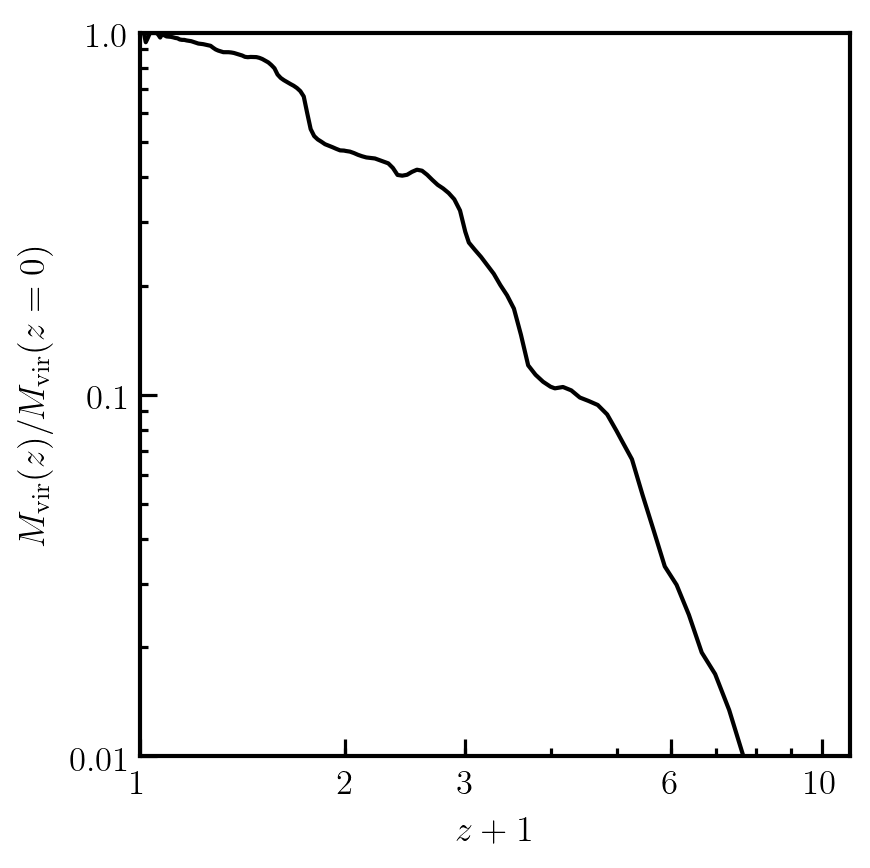

In [9]:
fig, ax = plt.subplots(figsize=(5.5/1.2,5.75/1.2),
                       ncols=1,nrows=1,
                        dpi=100)
plt.subplots_adjust(wspace=None, hspace=0.35)
ax.xaxis.set_tick_params(direction='in', which='both'); ax.yaxis.set_tick_params(direction='in', which='both')
ax.set_xlabel(r'$z+1$'); ax.set_ylabel(r'$M_{\rm vir}(z)/M_{\rm vir}(z=0)$')
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(1,11); ax.set_ylim(0.01,1)

ax.set_xticks([1,2,3,6,10])
ax.set_xticklabels([r'$1$',r'$2$',r'$3$',r'$6$',r'$10$'], fontsize=12.5)
ax.set_yticks([0.01,0.1,1.0])
ax.set_yticklabels([r'$0.01$',r'$0.1$',r'$1.0$'], fontsize=12.5)

x=host_tree['redshift']+1
y=host_tree['virial.mass']/host_tree['virial.mass'][0]

ax.plot(x,y,lw=1.5,color='k')

plt.show()

Now to the **satellite halo** data that we have saved in `nstree_id_`. We are going to update it by swifting out objects called "orphan" halos. These are halos that sometimes appear out of nowhere from the tree and fast flybys for the host. Objects like these are not typical in zoom-in simulations, but are apparent in large-box cosmologcial simulations. 

To find these objects, we'll loop through each satellite and throw out any that do not have main trees going beyond redshift $z=3$. This will update to an array called `nstree_id`.

In [10]:
#throw out orphan subhalos
nstree_id=[]
for tid in nstree_id_:
    w=np.where(tid==tree_ids)[0]; z=redshift[w]
    if(z[-1]>3):
        nstree_id.append(tid)
    else:
        pass
nstree_id=np.array(nstree_id)

I'll do the whole loop for each satellite, but I'll leave it up to you how you want to save each and every dataset. I'll save each halo with the tree id to a dictionary called `sat_data`.

In [11]:
cosmo=Cosmology(**params)
dyn=Dynamics(**params)

sat_data={} # contains the entire satellite tree data
ftree_id=[] # corrected satellite IDs
for tid in nstree_id[:]:
    sat_tree={}
    
    #partition out satellite quantities baed on tree depth
    ws=np.where(tid==tree_ids)[0];
    sat_tree['virial.mass']=tmvir[ws]
    sat_tree['scale']=scale[ws]; sat_tree['redshift']=redshift[ws]
    sat_tree['virial.radius']=sat_tree['scale']*trvir[ws]
    sat_tree['vel.max']=tvmax[ws] # physical kpc
    sat_tree['rad.max']=sat_tree['scale']*trmax[ws] # physical kpc
    sat_tree['rad.scale']=sat_tree['scale']*trs[ws] # physical kpc
    
    sat_tree['position']=np.zeros((sat_tree['scale'].shape[0],3)) # physical kpc
    sat_tree['position'][:,0]=sat_tree['scale']*xpos[ws]*1e3/h0
    sat_tree['position'][:,1]=sat_tree['scale']*ypos[ws]*1e3/h0
    sat_tree['position'][:,2]=sat_tree['scale']*zpos[ws]*1e3/h0
    
    sat_tree['velocity']=np.zeros((sat_tree['scale'].shape[0],3)) # peculiar km/s
    sat_tree['velocity'][:,0]=xvel[ws]; sat_tree['velocity'][:,1]=yvel[ws]; sat_tree['velocity'][:,2]=zvel[ws]

    '''Sometimes the satellite halos will have missing tree data at higher redshifts compared to MW, 
    which we expect to 'complete'. Below is a routine to make sure the host halo data and the satellite data 
    match at each snapshot/redshift.'''
    
    #partition out matching redshift host halo quantities
    wh=np.where(np.in1d(host_tree['scale'],sat_tree['scale']))[0]
    if(wh.shape[0]!=sat_tree['scale'].shape[0]):
        # I was too lazy to correct this...
        pass
    else:
        ftree_id.append(int(tid))
        sat_data[str(int(tid))]=sat_tree
            
        # matched snapshot host values
        # use these when doing dynamical analysis
        sat_tree['distance']=dyn.distance(sat_tree['redshift'],
                                          host_tree['position'][wh],sat_tree['position'])['relative.distance:magnitude']
        sat_tree['distance:pericenter']=min(sat_tree['distance'])
        
        sat_tree['total.velocity']=dyn.total_velocity(sat_tree['redshift'],host_tree['velocity'][wh],sat_tree['velocity'],host_tree['position'][wh],sat_tree['position'])['total.velocity:magnitude']
        sat_tree['radial.velocity']=dyn.radial_velocity(sat_tree['redshift'],host_tree['velocity'][wh],sat_tree['velocity'],host_tree['position'][wh],sat_tree['position'])
        sat_tree['tangential.velocity']=dyn.tangential_velocity(sat_tree['redshift'],host_tree['velocity'][wh],sat_tree['velocity'],host_tree['position'][wh],sat_tree['position'])
        sat_tree['space.velocity']=dyn.space_velocity(sat_tree['redshift'],host_tree['velocity'][wh],sat_tree['velocity'],host_tree['position'][wh],sat_tree['position'])
        
        sat_tree['distance.norm']=sat_tree['distance']/host_tree['virial.radius'][wh]

In [12]:
print(sat_data['25258073']['distance.norm'])
#print(sat_data['25258073']['radial.velocity'])

[4.48476261e-01 4.50984050e-01 4.47750867e-01 4.28901506e-01
 3.86738045e-01 3.69379312e-01 3.99183711e-01 4.31748602e-01
 4.37072105e-01 4.12619254e-01 3.60185137e-01 1.45940831e-01
 1.53180621e-01 1.99040073e-01 2.54488083e-01 3.10918077e-01
 3.56982498e-01 3.99593276e-01 4.39475715e-01 4.67184386e-01
 3.93630027e-01 5.09425440e-01 5.22532124e-01 5.29070083e-01
 5.26750079e-01 5.17153970e-01 5.00422486e-01 4.71377999e-01
 4.35157661e-01 3.92652758e-01 3.38967070e-01 2.82634262e-01
 2.30460541e-01 2.03219892e-01 2.47061174e-01 2.76505454e-01
 3.26309675e-01 3.77056231e-01 4.22960268e-01 4.62817061e-01
 4.96468245e-01 5.23737739e-01 5.46923219e-01 5.65525998e-01
 5.80102612e-01 5.91843086e-01 6.01426765e-01 6.12351246e-01
 6.21717772e-01 6.18778629e-01 6.03170079e-01 5.79173716e-01
 5.47561148e-01 5.07340567e-01 4.61630457e-01 4.12405044e-01
 3.66196424e-01 3.31359224e-01 3.31380971e-01 3.78059401e-01
 4.49779411e-01 5.24991165e-01 5.97993359e-01 6.72746355e-01
 7.51508639e-01 8.545303

# z=0 data from merger tree data

In [13]:
z0data={} # diectionary for z=0 data
z0data['virial.mass']=[] # Msol
z0data['vel.max']=[] # km/s
z0data['vel.peak']=[] # km/s
z0data['distance']=[] # kpc
z0data['distance:pericenter']=[] # kpc
z0data['distance.norm']=[]
z0data['virial.concentration']=[]

for sid in np.array(ftree_id):
    sat=sat_data[str(sid)]
    z0data['virial.mass'].append(sat['virial.mass'][0])
    z0data['distance'].append(sat['distance'][0]) # 1d float // distance at z=0 (present day)
    z0data['distance:pericenter'].append(min(sat['distance'][:])) # 1d float // distance at z=0 (present day)
    z0data['distance.norm'].append(sat['distance.norm'][0])
    z0data['vel.max'].append(sat['vel.max'][0])
    z0data['vel.peak'].append(max(sat['vel.max'][:]))
    z0data['virial.concentration'].append(sat['virial.radius'][0]/sat['rad.scale'][0]) 

In [30]:
def vmax0vpeak(rperi): # rperi in kpc
    alpha=5.80; beta=0.19
    return np.log10(alpha*(rperi/30.)**beta)

[ 10.          10.78189509  11.62492618  12.53387345  13.51389087
  14.57053536  15.70979837  16.9381398   18.26252464  19.69046248
  21.23005008  22.89001728  24.6797765   26.60947611  28.69005799
  30.93331955  33.35198062  35.95975562  38.77143127  41.80295046
  45.07150264  48.59562132  52.3952891   56.49205105  60.9091368
  65.67159232  70.80642189  76.34274128  82.31194276  88.74787317
  95.68702583 103.16874742 111.23546116 119.93290728 129.31040245
 139.42111937 150.32238828 162.07602206 174.74866669 188.41217919
 203.14403503 219.02776745 236.15344111 254.61816279 274.526632
 295.99173465 319.13518314 344.08820651 370.99229453 400.        ]
[ 10.          10.78189509  11.62492618  12.53387345  13.51389087
  14.57053536  15.70979837  16.9381398   18.26252464  19.69046248
  21.23005008  22.89001728  24.6797765   26.60947611  28.69005799
  30.93331955  33.35198062  35.95975562  38.77143127  41.80295046
  45.07150264  48.59562132  52.3952891   56.49205105  60.9091368
  65.67159232

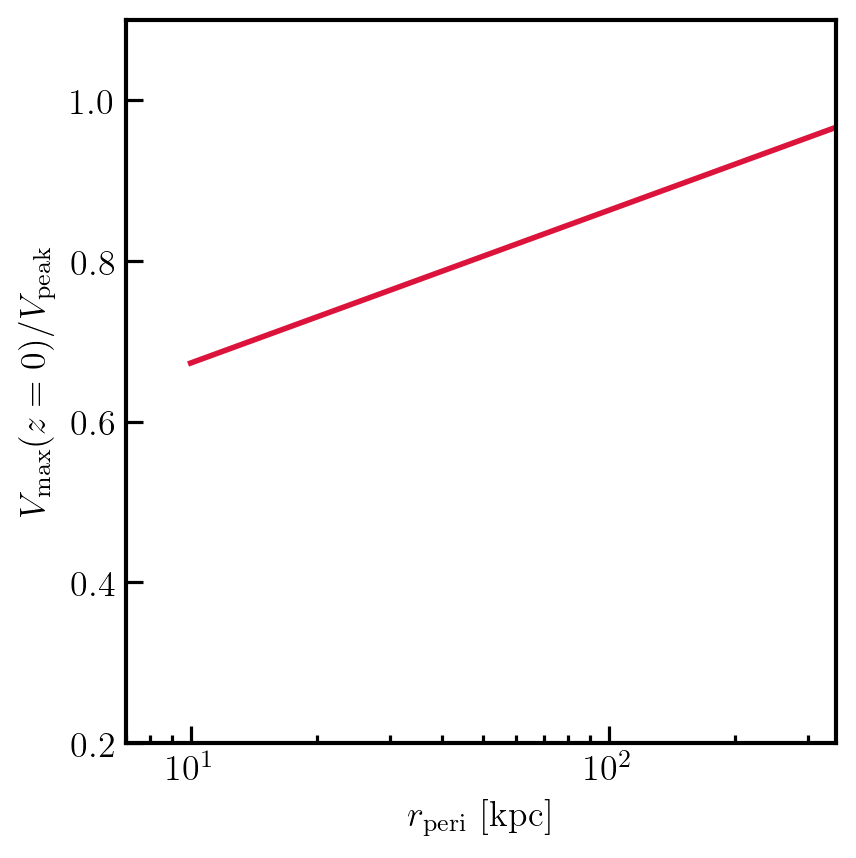

In [31]:
fig, ax = plt.subplots(figsize=(5.5/1.2,5.75/1.2),
                       ncols=1,nrows=1,
                        dpi=100)
plt.subplots_adjust(wspace=None, hspace=0.35)
ax.xaxis.set_tick_params(direction='in', which='both'); ax.yaxis.set_tick_params(direction='in', which='both')
ax.set_xlabel(r'$r_{\rm peri}\ [\rm kpc]$'); ax.set_ylabel(r'$V_{\rm max}(z=0)/V_{\rm peak}$')
ax.set_xscale('log'); 
ax.set_xlim(7,350); ax.set_ylim(0.2,1.1)

#x=z0data['distance:pericenter']
#y=np.array(z0data['vel.max'])/np.array(z0data['vel.peak'])
#ax.scatter(x,y,color='black',alpha=0.25)

rperi=10.**np.linspace(np.log10(10.),np.log10(400.))
rperi_=np.logspace(np.log10(10),np.log10(400))

print(rperi)
print(rperi_)

ax.plot(rperi,vmax0vpeak(rperi),color='crimson')


plt.show()

In [14]:
def vmax0vpeak(rperi): # rperi in kpc
    alpha=5.80; beta=0.19
    return np.log10(alpha*(rperi/30.)**beta)

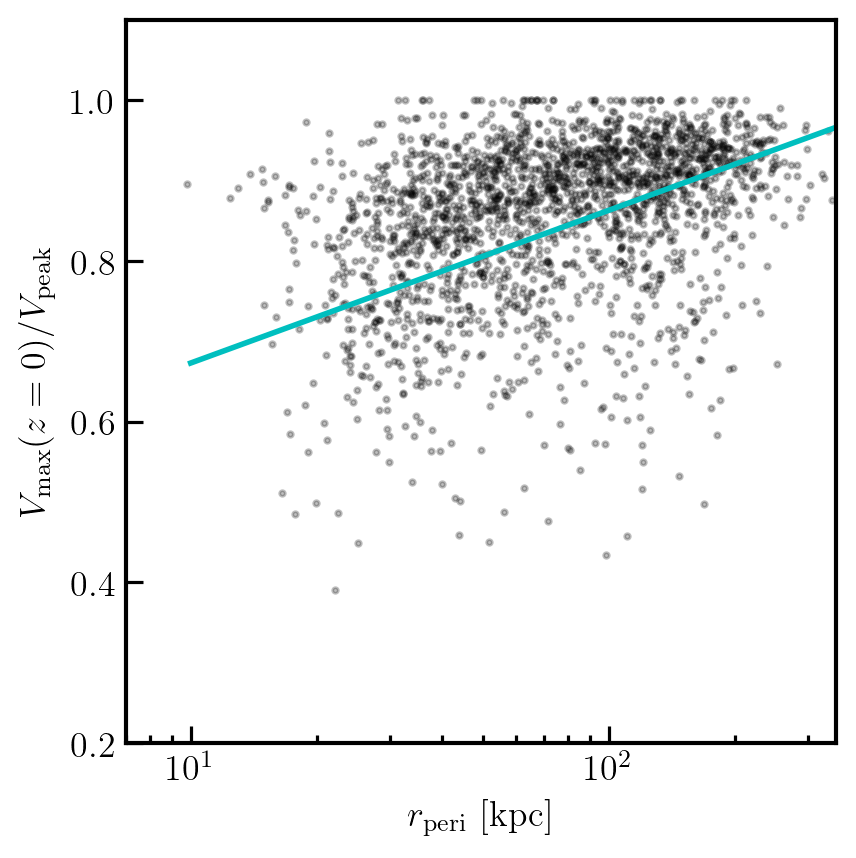

In [15]:
fig, ax = plt.subplots(figsize=(5.5/1.2,5.75/1.2),
                       ncols=1,nrows=1,
                        dpi=100)
plt.subplots_adjust(wspace=None, hspace=0.35)
ax.xaxis.set_tick_params(direction='in', which='both'); ax.yaxis.set_tick_params(direction='in', which='both')
ax.set_xlabel(r'$r_{\rm peri}\ [\rm kpc]$'); ax.set_ylabel(r'$V_{\rm max}(z=0)/V_{\rm peak}$')
ax.set_xscale('log'); 
ax.set_xlim(7,350); ax.set_ylim(0.2,1.1)

x=z0data['distance:pericenter']
y=np.array(z0data['vel.max'])/np.array(z0data['vel.peak'])
ax.scatter(x,y,color='black',alpha=0.25)

rper=10.**np.linspace(np.log10(10.),np.log10(400.))
ax.plot(rper,vmax0vpeak(rper),color='c')

plt.show()

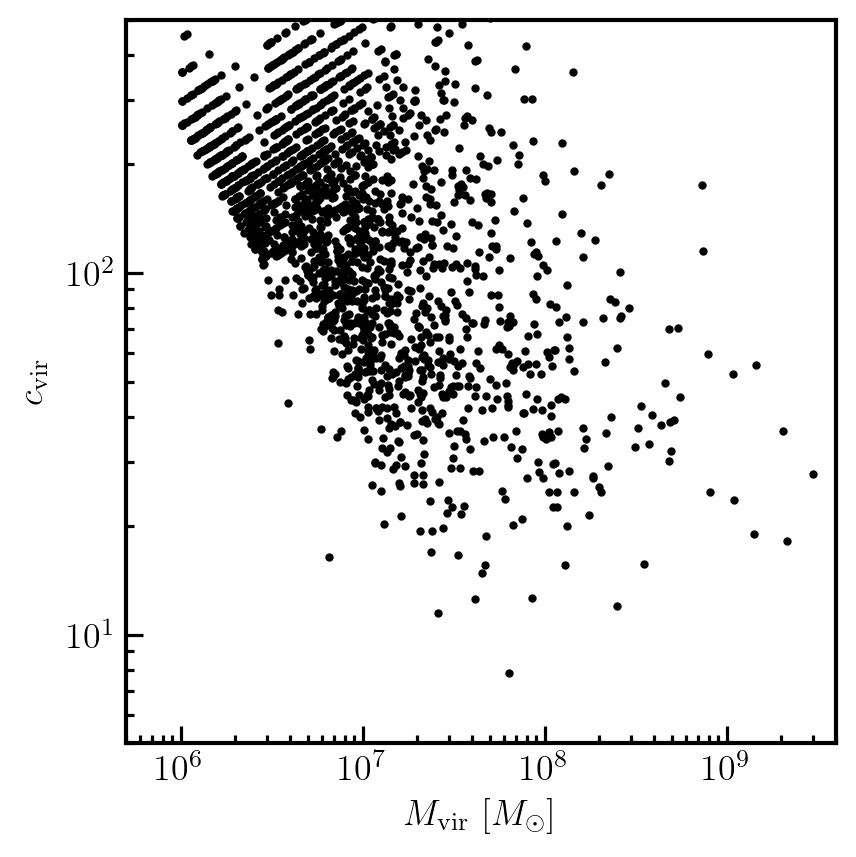

In [14]:
fig, ax = plt.subplots(figsize=(5.5/1.2,5.75/1.2),
                       ncols=1,nrows=1,
                        dpi=100)
plt.subplots_adjust(wspace=None, hspace=0.35)
ax.xaxis.set_tick_params(direction='in', which='both'); ax.yaxis.set_tick_params(direction='in', which='both')
ax.set_xlabel(r'$M_{\rm vir}\ [M_{\odot}]$'); ax.set_ylabel(r'$c_{\rm vir}$')
ax.set_xscale('log'); ax.set_yscale('log')

ax.set_xlim(5e5,4e9)
ax.set_ylim(5,500); 

#ax.set_xticks([1,2,3,6,10])
#ax.set_xticklabels([r'$1$',r'$2$',r'$3$',r'$6$',r'$10$'], fontsize=12.5)
#ax.set_yticks([1e6,0.1,1.0,5.0])
#ax.set_yticklabels([r'$0.01$',r'$0.1$',r'$1.0$',r'$5.0$'], fontsize=12.5)

# plotting data
x=z0data['virial.mass']
y=z0data['virial.concentration']
ax.scatter(x,y,color='k')
        
plt.show()

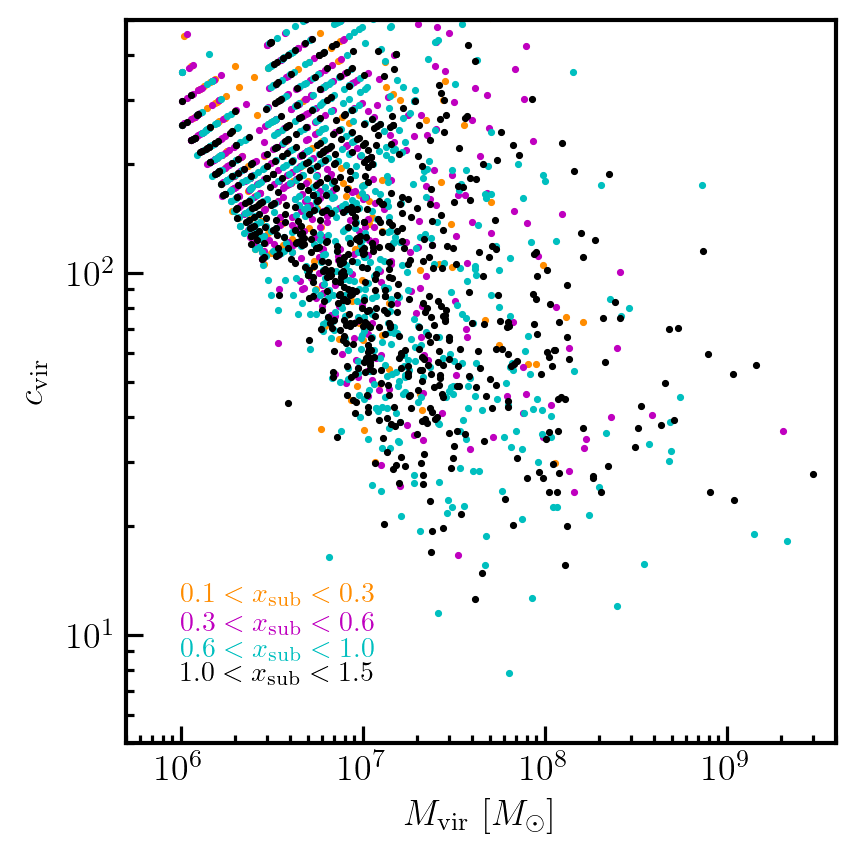

In [15]:
fig, ax = plt.subplots(figsize=(5.5/1.2,5.75/1.2),
                       ncols=1,nrows=1,
                        dpi=100)
plt.subplots_adjust(wspace=None, hspace=0.35)
ax.xaxis.set_tick_params(direction='in', which='both'); ax.yaxis.set_tick_params(direction='in', which='both')
ax.set_xlabel(r'$M_{\rm vir}\ [M_{\odot}]$'); ax.set_ylabel(r'$c_{\rm vir}$')
ax.set_xscale('log'); ax.set_yscale('log')

ax.set_xlim(5e5,4e9)
ax.set_ylim(5,500); 

#ax.set_xticks([1,2,3,6,10])
#ax.set_xticklabels([r'$1$',r'$2$',r'$3$',r'$6$',r'$10$'], fontsize=12.5)
#ax.set_yticks([1e6,0.1,1.0,5.0])
#ax.set_yticklabels([r'$0.01$',r'$0.1$',r'$1.0$',r'$5.0$'], fontsize=12.5)

# plotting data
x=np.array(z0data['virial.mass'])
y=np.array(z0data['virial.concentration'])
z=np.array(z0data['distance.norm'])


w1=np.where(z<0.1)[0]
#ax.scatter(x[w1],y[w1],s=1,color='crimson')

w2=np.where((0.1<z)&(z<0.3))[0]
ax.scatter(x[w2],y[w2],s=2.5,color='darkorange')
ax.text(1e6,12,r'$0.1<x_{\rm sub}<0.3$',color='darkorange')
    
w3=np.where((0.3<z)&(z<0.6))[0]
ax.scatter(x[w3],y[w3],s=2.5,color='m')
ax.text(1e6,10,r'$0.3<x_{\rm sub}<0.6$',color='m')

w3=np.where((0.6<z)&(z<1.0))[0]
ax.scatter(x[w3],y[w3],s=2.5,color='c')
ax.text(1e6,8.45,r'$0.6<x_{\rm sub}<1.0$',color='c')

w4=np.where((1.0<z)&(z<1.5))[0]
ax.scatter(x[w4],y[w4],s=2.5,color='k')
ax.text(1e6,7.25,r'$1.0<x_{\rm sub}<1.5$',color='k')



plt.show()

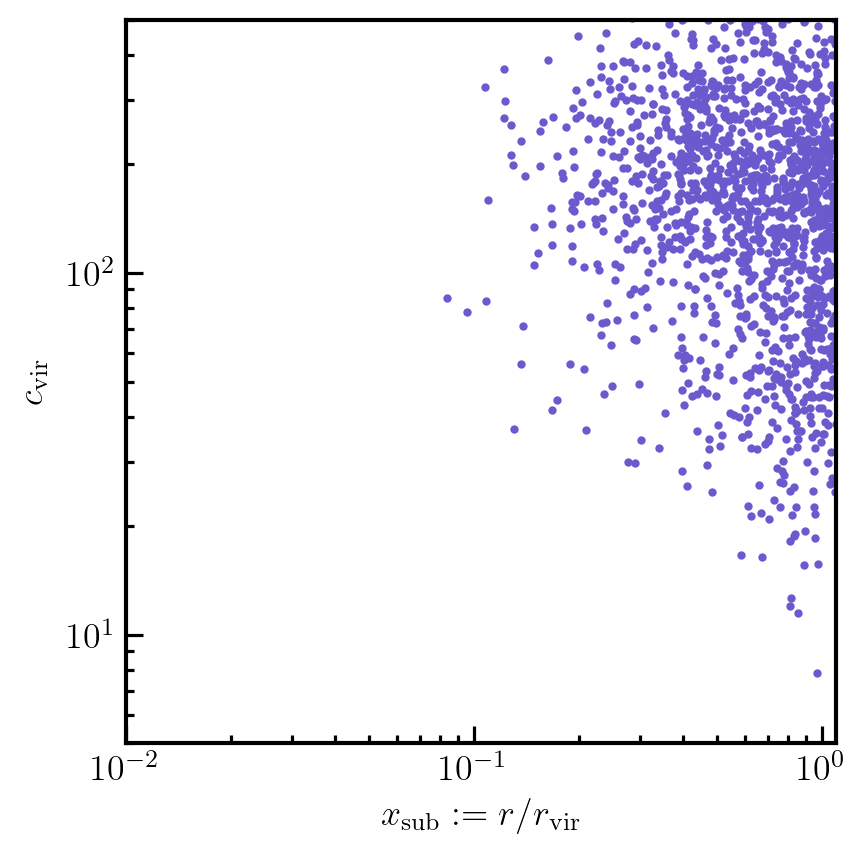

In [16]:
fig, ax = plt.subplots(figsize=(5.5/1.2,5.75/1.2),
                       ncols=1,nrows=1,
                        dpi=100)
plt.subplots_adjust(wspace=None, hspace=0.35)
ax.xaxis.set_tick_params(direction='in', which='both'); ax.yaxis.set_tick_params(direction='in', which='both')
ax.set_xlabel(r'$x_{\rm sub}:=r/r_{\rm vir}$'); ax.set_ylabel(r'$c_{\rm vir}$')
ax.set_xscale('log'); ax.set_yscale('log')

ax.set_xlim(0.01,1.1)
ax.set_ylim(5,500); 

#ax.set_xticks([1,2,3,6,10])
#ax.set_xticklabels([r'$1$',r'$2$',r'$3$',r'$6$',r'$10$'], fontsize=12.5)
#ax.set_yticks([1e6,0.1,1.0,5.0])
#ax.set_yticklabels([r'$0.01$',r'$0.1$',r'$1.0$',r'$5.0$'], fontsize=12.5)

# plotting data
x=z0data['distance.norm']
y=z0data['virial.concentration']
ax.scatter(x,y,color='slateblue')
        
plt.show()